## Loading Financial Data

In [255]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
from datetime import timedelta

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler                # Scale the data between 0 and 1
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential

In [246]:
crypto_currency = 'BTC'
against_currency = 'USD'

In [247]:
start = dt.datetime(2015,1,1)
end = dt.datetime.now()

In [109]:
data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)

In [234]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-01,320.434998,314.002991,320.434998,314.248993,8036550,314.248993
2015-01-02,315.838989,313.565002,314.079010,315.032013,7860650,315.032013
2015-01-03,315.149994,281.082001,314.846008,281.082001,33054400,281.082001
2015-01-04,287.230011,257.612000,281.145996,264.195007,55629100,264.195007
2015-01-05,278.341003,265.084015,265.084015,274.473999,43962800,274.473999


## Data Preparation

In [111]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [112]:
# Number of days where the prediction is based on
prediction_days = 60
#future_day = 7

In [113]:
# Train Data
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)): # - future_day):
    x_train.append(scaled_data[x - prediction_days: x, 0])
    y_train.append(scaled_data[x, 0])  # + future_days

In [114]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Model Layers

In [115]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2)) 

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train, y_train, epochs = 25, batch_size = 32)

Epoch 1/25
82/82 [==============================] - 9s 62ms/step - loss: 0.0069
Epoch 2/25
82/82 [==============================] - 5s 63ms/step - loss: 0.0032
Epoch 3/25
82/82 [==============================] - 5s 63ms/step - loss: 0.0025
Epoch 4/25
82/82 [==============================] - 5s 62ms/step - loss: 0.0022
Epoch 5/25
82/82 [==============================] - 5s 63ms/step - loss: 0.0021
Epoch 6/25
82/82 [==============================] - 5s 63ms/step - loss: 0.0018
Epoch 7/25
82/82 [==============================] - 5s 62ms/step - loss: 0.0017
Epoch 8/25
82/82 [==============================] - 5s 63ms/step - loss: 0.0017
Epoch 9/25
82/82 [==============================] - 5s 63ms/step - loss: 0.0017
Epoch 10/25
82/82 [==============================] - 5s 63ms/step - loss: 0.0017
Epoch 11/25
82/82 [==============================] - 5s 63ms/step - loss: 0.0017
Epoch 12/25
82/82 [==============================] - 5s 62ms/step - loss: 0.0015
Epoch 13/25
82/82 [==================

## Testing the Model

In [179]:
test_start = dt.datetime(2017,1,1)   # Starts date of the data
test_end = dt.datetime.now()

test_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

In [180]:
total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)

In [181]:
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.fit_transform(model_inputs)

In [185]:
len(model_inputs)

2001

In [187]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [188]:
# Predict Prices
prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

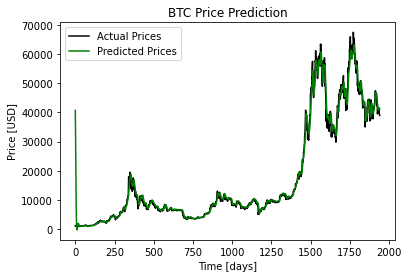

In [190]:
# Plotting
plt.plot(actual_prices, color = 'black', label = 'Actual Prices')
plt.plot(prediction_prices, color = 'green', label = 'Predicted Prices')
plt.title(f'{crypto_currency} Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price [USD]')
plt.legend(loc = 'upper left')
plt.show()

In [268]:
next_day_prediction = []

next_day_prediction = [(end + timedelta(1)).strftime('%Y-%m-%d'), prediction_prices[-1]]

print(next_day_prediction)

['2022-04-26', array([41103.453], dtype=float32)]
